In [18]:
# USAGE
# python train.py --dataset dataset
import warnings
warnings.filterwarnings("ignore")
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import glob

In [29]:
INIT_LR = 1e-3
EPOCHS = 20
BS = 10


print("[INFO] loading images...")
imagePathsNormal = list(glob.glob("dataset/normal/*"))
imagePathsCovid = list(glob.glob("dataset/covid/*"))
imagePaths = imagePathsNormal + imagePathsCovid
data = []
labels = []

for imagePath in imagePaths:

    label = imagePath.split(os.path.sep)[-2]

    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    data.append(image)
    labels.append(label)

print(labels)

[INFO] loading images...
['dataset/normal', 'dataset/normal', 'dataset/normal', 'dataset/normal', 'dataset/normal', 'dataset/normal', 'dataset/normal', 'dataset/normal', 'dataset/normal', 'dataset/normal', 'dataset/normal', 'dataset/normal', 'dataset/normal', 'dataset/normal', 'dataset/normal', 'dataset/normal', 'dataset/normal', 'dataset/normal', 'dataset/normal', 'dataset/normal', 'dataset/normal', 'dataset/normal', 'dataset/normal', 'dataset/normal', 'dataset/normal', 'dataset/covid', 'dataset/covid', 'dataset/covid', 'dataset/covid', 'dataset/covid', 'dataset/covid', 'dataset/covid', 'dataset/covid', 'dataset/covid', 'dataset/covid', 'dataset/covid', 'dataset/covid', 'dataset/covid', 'dataset/covid', 'dataset/covid', 'dataset/covid', 'dataset/covid', 'dataset/covid', 'dataset/covid', 'dataset/covid', 'dataset/covid', 'dataset/covid', 'dataset/covid', 'dataset/covid', 'dataset/covid']


In [30]:



data = np.array(data) / 255.0
labels = np.array(labels)


lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)


(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

trainAug = ImageDataGenerator(
    rotation_range=15,
    fill_mode="nearest")


baseModel = VGG16(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))


headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


model = Model(inputs=baseModel.input, outputs=headModel)


for layer in baseModel.layers:
	layer.trainable = False

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("[INFO] training head...")
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)



predIdxs = np.argmax(predIdxs, axis=1)


print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))


cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))




58892288/58889256 [==============================] - 6s 0us/step
[INFO] compiling model...
[INFO] training head...
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
4/4 [==============================] - 10s 2s/step - loss: 1.0441 - accuracy: 0.4250 - val_loss: 0.7551 - val_accuracy: 0.5000
Epoch 2/20
4/4 [==============================] - 10s 3s/step - loss: 0.7666 - accuracy: 0.5750 - val_loss: 0.6722 - val_accuracy: 0.4000
Epoch 3/20
4/4 [==============================] - 12s 3s/step - loss: 0.7874 - accuracy: 0.5250 - val_loss: 0.6873 - val_accuracy: 0.5000
Epoch 4/20
4/4 [==============================] - 11s 3s/step - loss: 0.8570 - accuracy: 0.5000 - val_loss: 0.6568 - val_accuracy: 0.6000
Epoch 5/20
4/4 [==============================] - 11s 3s/step - loss: 0.6772 - accuracy: 0.5500 - val_loss: 0.6502 - val_accuracy: 0.6000
Epoch 6/20
4/4 [==============================] - 11s 3s/step - loss: 0.6460 - accuracy: 0.6000 - val_loss: 0.6441 - va

NameError: name 'args' is not defined

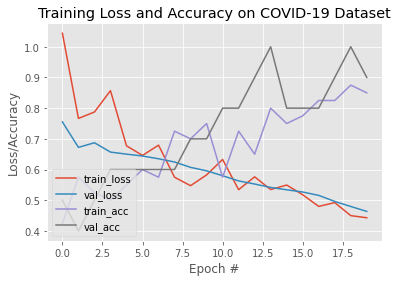

In [31]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])


print("[INFO] saving COVID-19 detector model...")
model.save(args["model"], save_format="h5")